Importing necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import sklearn

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
demand = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Repo/demand_final.csv')
sources = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Repo/sources_final.csv')

In [3]:
demand = demand[0:1000]

In [4]:
sources = sources[0:1000]
sources = sources.drop('Time', axis=1)

In [5]:
result = pd.concat([demand, sources], axis=1, join='inner')
result

,Time,Day ahead forecast,Hour ahead forecast,Current demand,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro
0,00:00,21112.0,20527.0,20564.0,0.0,3381.0,964.0,217.0,183.0,453.0,10.0,2283.0,4286.0,3912.0,-3.0,5950.0,0.0,NaN,NaN
1,00:05,20262.0,20395.0,20510.0,0.0,3403.0,964.0,217.0,183.0,452.0,10.0,2282.0,4069.0,3899.0,80.0,6143.0,0.0,NaN,NaN
2,00:10,20262.0,20395.0,20447.0,0.0,3463.0,964.0,219.0,184.0,420.0,10.0,2283.0,3687.0,4060.0,48.0,6171.0,0.0,NaN,NaN
3,00:15,20262.0,20395.0,20335.0,0.0,3455.0,965.0,219.0,183.0,422.0,9.0,2282.0,3545.0,3996.0,-68.0,6460.0,0.0,NaN,NaN
4,00:20,20262.0,20160.0,20206.0,0.0,3440.0,965.0,220.0,184.0,421.0,9.0,2280.0,3600.0,3934.0,-51.0,6460.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10:40,23785.0,21777.0,21742.0,7546.0,1902.0,960.0,299.0,224.0,407.0,12.0,2278.0,1970.0,2390.0,-60.0,622.0,0.0,NaN,NaN
996,10:45,23785.0,21777.0,21725.0,7598.0,1925.0,960.0,299.0,223.0,408.0,12.0,2278.0,1940.0,2306.0,-60.0,590.0,0.0,NaN,NaN
997,10:50,23785.0,21568.0,21648.0,7387.0,1867.0,961.0,298.0,223.0,408.0,12.0,2278.0,2074.0,2325.0,-26.0,606.0,0.0,NaN,NaN
998,10:55,23785.0,21568.0,21576.0,7306.0,1826.0,959.0,295.0,224.0,411.0,12.0,2277.0,2116.0,2451.0,-11.0,544.0,0.0,NaN,NaN


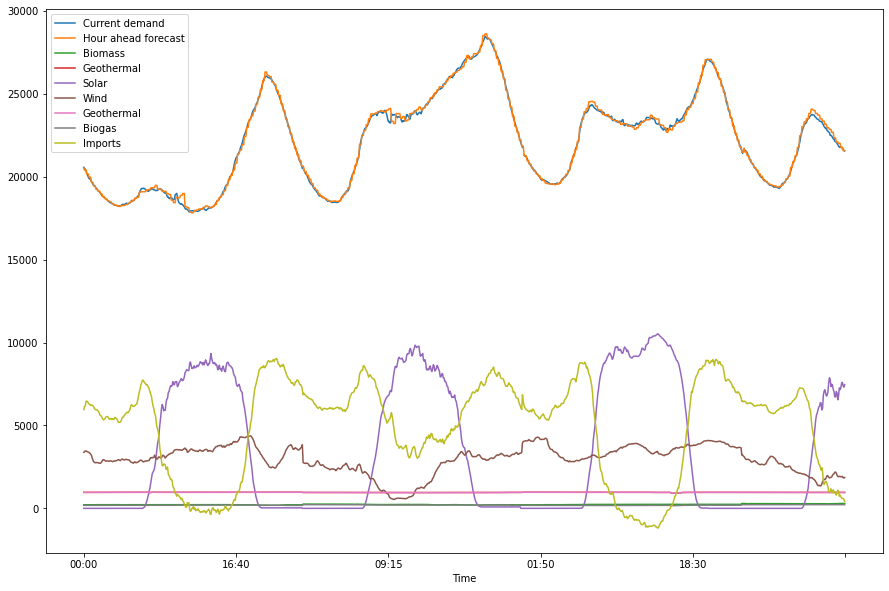

In [6]:
result.plot(y=["Current demand", "Hour ahead forecast", "Biomass", 'Geothermal', 'Solar', 'Wind', 'Geothermal', 'Biogas', "Imports"], x="Time", figsize=(15, 10))

In [7]:
clusterSources = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Repo/sources_final.csv')
clusterSources = clusterSources[0:289]

In [8]:
df = clusterSources.drop(['Time'], axis = 1)
df

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro
0,0.0,3381.0,964.0,217.0,183.0,453.0,10.0,2283.0,4286.0,3912.0,-3.0,5950.0,0.0,NaN,NaN
1,0.0,3403.0,964.0,217.0,183.0,452.0,10.0,2282.0,4069.0,3899.0,80.0,6143.0,0.0,NaN,NaN
2,0.0,3463.0,964.0,219.0,184.0,420.0,10.0,2283.0,3687.0,4060.0,48.0,6171.0,0.0,NaN,NaN
3,0.0,3455.0,965.0,219.0,183.0,422.0,9.0,2282.0,3545.0,3996.0,-68.0,6460.0,0.0,NaN,NaN
4,0.0,3440.0,965.0,220.0,184.0,421.0,9.0,2280.0,3600.0,3934.0,-51.0,6460.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,31.0,3596.0,971.0,211.0,178.0,456.0,10.0,2282.0,2304.0,3889.0,19.0,7452.0,0.0,NaN,NaN
285,31.0,3650.0,971.0,213.0,178.0,456.0,10.0,2282.0,2313.0,3852.0,-59.0,7447.0,0.0,NaN,NaN
286,31.0,3691.0,971.0,213.0,177.0,456.0,10.0,2282.0,2297.0,3880.0,-83.0,7350.0,0.0,NaN,NaN
287,0.0,3834.0,971.0,216.0,178.0,457.0,10.0,2282.0,2260.0,3874.0,-98.0,7148.0,0.0,NaN,NaN


In [9]:
df = df.replace(np.nan,0)
df

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro
0,0.0,3381.0,964.0,217.0,183.0,453.0,10.0,2283.0,4286.0,3912.0,-3.0,5950.0,0.0,0.0,0.0
1,0.0,3403.0,964.0,217.0,183.0,452.0,10.0,2282.0,4069.0,3899.0,80.0,6143.0,0.0,0.0,0.0
2,0.0,3463.0,964.0,219.0,184.0,420.0,10.0,2283.0,3687.0,4060.0,48.0,6171.0,0.0,0.0,0.0
3,0.0,3455.0,965.0,219.0,183.0,422.0,9.0,2282.0,3545.0,3996.0,-68.0,6460.0,0.0,0.0,0.0
4,0.0,3440.0,965.0,220.0,184.0,421.0,9.0,2280.0,3600.0,3934.0,-51.0,6460.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,31.0,3596.0,971.0,211.0,178.0,456.0,10.0,2282.0,2304.0,3889.0,19.0,7452.0,0.0,0.0,0.0
285,31.0,3650.0,971.0,213.0,178.0,456.0,10.0,2282.0,2313.0,3852.0,-59.0,7447.0,0.0,0.0,0.0
286,31.0,3691.0,971.0,213.0,177.0,456.0,10.0,2282.0,2297.0,3880.0,-83.0,7350.0,0.0,0.0,0.0
287,0.0,3834.0,971.0,216.0,178.0,457.0,10.0,2282.0,2260.0,3874.0,-98.0,7148.0,0.0,0.0,0.0


In [ ]:
plt.scatter(df[:0], df[:1], sc=10, c='black')

Finding the optimal no of clusters

In [14]:
from sklearn.cluster import KMeans

In [ ]:
wcss = []
for i in range(0,15):
  kmeans = KMeans(n_clusters = i) #no-of clusters = 15
  init = 'kmeans++', max_iter = 300, n_init = 15
  kmeans.fit(df)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,15), wcss)
plt.tittle('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(ep=5, min_samples=5)  

In [ ]:
labels = dbscan.fit_predict(df)

In [ ]:
np.unique(labels)

Visualizing the Clusters

In [ ]:
plt.scatter(df.iloc[labels == -1,0], df[labels == -1,1], s=10, c='black')

plt.scatter(df.iloc[labels == 0,0], df[labels == 0,1], s=10, c='blue')
plt.scatter(df.iloc[labels == 1,0], df[labels == 1,1], s=10, c='red')
plt.scatter(df.iloc[labels == 2,0], df[labels == 2,1], s=10, c='green')
plt.scatter(df.iloc[labels == 3,0], df[labels == 3,1], s=10, c='brown')
plt.scatter(df.iloc[labels == 4,0], df[labels == 4,1], s=10, c='pink')
plt.scatter(df.iloc[labels == 5,0], df[labels == 5,1], s=10, c='yellow')
plt.scatter(df.iloc[labels == 6,0], df[labels == 6,1], s=10, c='silver')

plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()